<a href="https://colab.research.google.com/github/2022yingjie/Digital-Images-Processing/blob/main/YOLOV8_Skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# YOLOV8 Train Human Skeleton keypoints detection model by using YOLOV8

## Transfer .json files from Labelme to YOLO format, the related function is shown as following:
"""
Transfer labelme data format into YOLO data format
"""
import os
import json
import numpy as np




# 框的类别
bbox_class = {
    'box':0
}
# 关节点的类
keypoint_class = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19']
def process_json_YOLO(labelme,coco_path):
    img_width = labelme['imageWidth']
    img_height = labelme['imageHeight']
    with open(coco_path, 'w', encoding='utf-8') as f:
        for each_ann in labelme['shapes']: # 遍历每个标注
            if each_ann['label'] == 'box': # 如果遇到框

                yolo_str = ''

                ## 框的信息
                # 框的类别 ID
                bbox_class_id = bbox_class[each_ann['label']]
                yolo_str += '{} '.format(bbox_class_id)
                # 左上角和右下角的 XY 像素坐标
                bbox_top_left_x = int(min(each_ann['points'][0][0], each_ann['points'][1][0]))
                bbox_bottom_right_x = int(max(each_ann['points'][0][0], each_ann['points'][1][0]))
                bbox_top_left_y = int(min(each_ann['points'][0][1], each_ann['points'][1][1]))
                bbox_bottom_right_y = int(max(each_ann['points'][0][1], each_ann['points'][1][1]))
                # 框中心点的 XY 像素坐标
                bbox_center_x = int((bbox_top_left_x + bbox_bottom_right_x) / 2)
                bbox_center_y = int((bbox_top_left_y + bbox_bottom_right_y) / 2)
                # 框宽度
                bbox_width = bbox_bottom_right_x - bbox_top_left_x
                # 框高度
                bbox_height = bbox_bottom_right_y - bbox_top_left_y
                # 框中心点归一化坐标
                bbox_center_x_norm = bbox_center_x / img_width
                bbox_center_y_norm = bbox_center_y / img_height
                # 框归一化宽度
                bbox_width_norm = bbox_width / img_width
                # 框归一化高度
                bbox_height_norm = bbox_height / img_height

                yolo_str += '{:.5f} {:.5f} {:.5f} {:.5f} '.format(bbox_center_x_norm, bbox_center_y_norm, bbox_width_norm, bbox_height_norm)

                ## 找到该框中所有关键点，存在字典 bbox_keypoints_dict 中
                bbox_keypoints_dict = {}
                for each_ann in labelme['shapes']: # 遍历所有标注
                    if each_ann['label'] in keypoint_class: # 筛选出关键点标注
                        # 关键点XY坐标、类别
                        x = int(each_ann['points'][0][0])
                        y = int(each_ann['points'][0][1])
                        label = each_ann['label']
                        if (x>bbox_top_left_x) & (x<bbox_bottom_right_x) & (y<bbox_bottom_right_y) & (y>bbox_top_left_y): # 筛选出在该个体框中的关键点
                            bbox_keypoints_dict[label] = [x, y]
                #print(bbox_keypoints_dict)
                ## 把关键点按顺序排好
                for each_class in keypoint_class: # 遍历每一类关键点
                    if each_class in bbox_keypoints_dict:
                        keypoint_x_norm = bbox_keypoints_dict[each_class][0] / img_width
                        keypoint_y_norm = bbox_keypoints_dict[each_class][1] / img_height
                        yolo_str += '{:.5f} {:.5f} {} '.format(keypoint_x_norm, keypoint_y_norm, 2) # 2-可见不遮挡 1-遮挡 0-没有点
                    else: # 不存在的点，一律为0
                        yolo_str += '0 0 0 '.format(keypoint_x_norm, keypoint_y_norm, 0)

                print(yolo_str)
                # 写入 txt 文件中
                f.write(yolo_str + '\n')

    print('转换完成')



def Convert_Labelme2YOLO(labelme,coco_path):
    coco = process_json_YOLO(labelme=labelme,coco_path=coco_path)
    return coco


root_path = "Z:\Whole Body DXA IMAGE"
NameList = os.listdir(root_path)


for idx in range(100,200):
    #print(name)
    json_name = os.path.join(root_path,str(idx),'skeleton.json')
    coco_path = os.path.join(root_path, str(idx), 'output_yolo.txt')
    with open(json_name, 'r', encoding='utf-8') as f:
        labelme = json.load(f)
        # print(labelme.keys())
        coco = Convert_Labelme2YOLO(labelme,coco_path)


        # with open(coco_path, 'w') as f:
        #     json.dump(coco,f,indent=2)


In [ ]:
# How to Train our dataset

# Defined Our own .yaml configuration document

###################################Skeleton.yaml######################################
# 数据集在 datasets 目录下的文件夹路径
path: Z:\Semi_Keypoints_Detection  #Z:\Semi_Keypoints_Detection # Z:\skeleton_xrays

# 训练集、验证集、测试集相对于 path 的路径（一般不用区分验证集和测试集，统称测试集）
train: images/train
val: images/val
test: images/val

# number of classes
nc: 1

# 3 种关键点，每个关键点有 X Y 是否可见 三个参数
# 是否可见：2-可见不遮挡 1-遮挡 0-没有点
kpt_shape: [19, 3] # number of points and its dimension

# 框的类别（对于关键点检测，只有一类）
names:
  0: skeleton



###################################Training######################################
"""
Using YOLO API
"""

# import package
from ultralytics import YOLO

# three approaches to load model
model = YOLO('Skeleton.yaml')# 加载配置文件，从头开始训练
model = YOLO('yolov8s-pose.pt')# 调用预训练权重
model = YOLO('Skeleton.yaml').load('yolov8s-pose.pt')# 加载配置文件，用自己设定的类但同时调用预训练权重

# Train the model,many parameters, go to check the web  https://docs.ultralytics.com/modes/
model.train(data='coco128.yaml', epochs=100, imgsz=960,batch=12,project='Project_Name', name='Name of current training',model='yolov8s-pose.pt',device=0,pretrained=True)

# Validate the model
model.val()

# Predict the model
model.predict()


###### Command of YOLOV8
# 1. Train
# yolo pose train data=Skeleton.yaml model=yolov8s-pose.pt pretrained=True project=XR_Skeleton name=xrays_skeleton epochs=300 imgsz=960 batch=12 device=0

# 2. Val
# yolo detect val model=yolov8n.pt  # val official model
# yolo detect val model=path/to/best.pt  # val custom model

# 3. Predict
# Go to check the web https://docs.ultralytics.com/modes/predict/#inference-arguments

In [2]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 646.6/646.6 kB 7.3 MB/s eta 0:00:00



image 1/1 /content/skeleton.png: 960x960 1 skeleton, 3106.9ms
Speed: 14.6ms preprocess, 3106.9ms inference, 2.1ms postprocess per image at shape (1, 3, 960, 960)


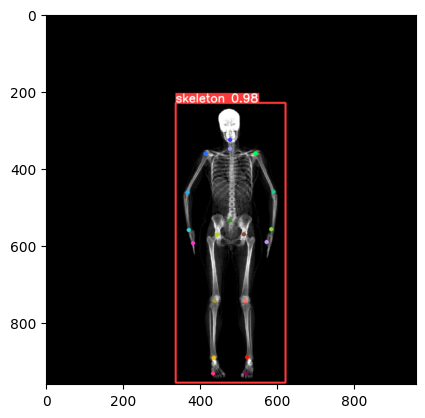

In [5]:
# Using trained model to show the detection results of human skeleton x-ray images
from ultralytics import YOLO
import os
import matplotlib.pyplot as plt
from PIL import Image
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

model = YOLO("/content/best.pt")
results = model("/content/skeleton.png")
for r in results:
  im_array = r.plot()
  im = Image.fromarray(im_array[...,::-1])
  # im.show()
  plt.figure()
  plt.imshow(im)
  plt.show()